In [1]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import mne
from mne_bids import BIDSPath, read_raw_bids

from timescales.autoreg import compute_ar_spectrum

from neurodsp.spectral import compute_spectrum
import matplotlib.pyplot as plt

from timescales.fit import PSD
from neurodsp.utils.norm import normalize_sig

import warnings
warnings.filterwarnings("ignore")

### EEG Features

This analysis uses "A Dataset of Scalp EEG Recordings of Alzheimer’s Disease, Frontotemporal Dementia and Healthy Subjects from Routine EEG" from Miltiadous et al., 2023 and available from [openneuro](https://openneuro.org/datasets/ds004504/versions/1.0.5). The goal of the analysis is to extract interpretable features from power spectral density and then train a sparse logistic regression risk model to predict Alzhiemer's patients from helthy controls.

In [2]:
# Fit linear function to low frequencies
def linear(xs, slope, offset):
    return offset - np.log10(xs**slope)

def compute_features(sig):
    """Computes spectral features."""
    # Compute power spectrum
    fs = 500
    freqs, powers = compute_ar_spectrum(normalize_sig(sig, 0, 1), fs, order=100, f_range=(.001, 225))

    # Fit linear model to low frequencies
    f_range = (0, 5)

    low_inds = np.where((freqs > f_range[0]) & (freqs <= f_range[1]))[0]

    params, _ = curve_fit(linear, freqs[low_inds], np.log10(powers[low_inds]), bounds=((-10, -100), (10, 100)),
                          loss="huber", f_scale=.25, sigma=np.logspace(-3, 0, len(low_inds)))

    slope = params[0]
    offset = params[1]

    linear_rsq = np.corrcoef(linear(freqs[low_inds], slope, offset), np.log10(powers[low_inds]))[0][1]**2

    # Fit Lorentzian to high frequencies
    hi_inds = np.where(freqs > f_range[1])[0]

    psd = PSD()
    psd.fit(freqs[hi_inds], powers[hi_inds], f_range=(f_range[1], 225), f_scale=.1, ap_mode="double")

    params = np.insert(psd.params, [0, 0], [slope, offset])
    param_names = []
    param_names += ["linear_slope", "linear_offset"]
    param_names += ["alpha_"+i for i in  psd.param_names]
    param_names += ["gamma_"+i for i in  psd.param_names]

    lorentzian_rsq = psd.rsq

    X = (freqs, powers)
    inds = (low_inds, hi_inds)
    params = (params, param_names)
    rsq = (linear_rsq, lorentzian_rsq)
    
    return X, inds, params, psd, rsq

## Features

Below, spectral features are computed across all eeg electrodes for an example subject. After verying that the features are resonable, this process will be applied to all subjects.

In [3]:
# Load example subject
bids_path = BIDSPath(subject="001", task="eyesclosed", datatype="eeg",
                     extension=".set", root="./ds004504-download", check=False)
bids = read_raw_bids(bids_path=bids_path, verbose=False)

X = bids.get_data()

# Compute fatures
X, inds, params, psd, rsq = compute_features(X[0])

# Unpack results
freqs, powers = X
low_inds, hi_inds = inds
params, param_names = params
linear_rsq, lorentzian_rsq = rsq

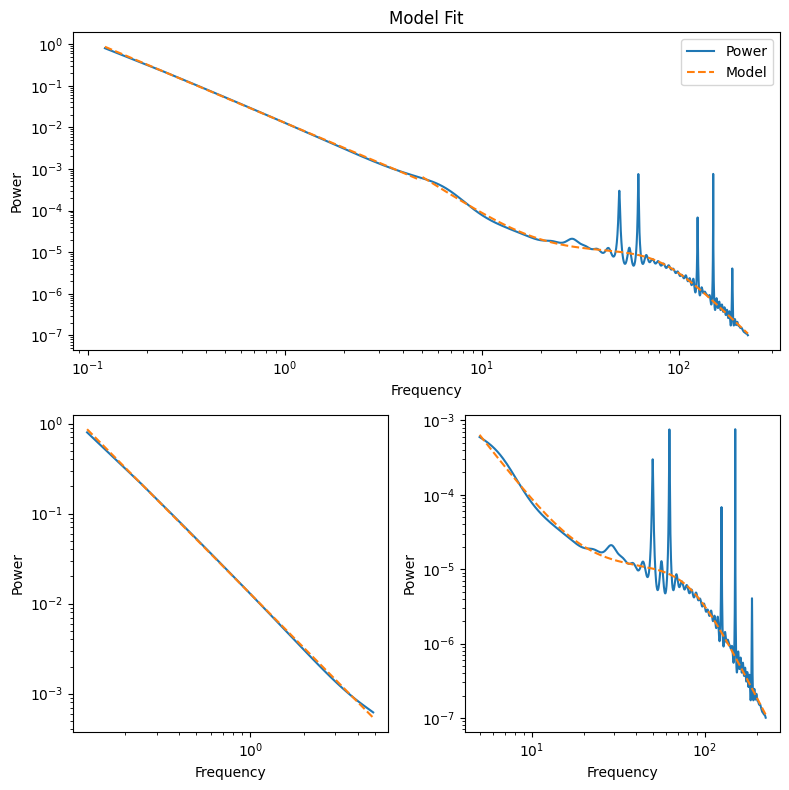

In [4]:
# Plot example subject
slope = params[0]
offset = params[1]

fig = plt.figure(tight_layout=True, figsize=(8, 8))
gs = gridspec.GridSpec(10, 2)

ax = fig.add_subplot(gs[:5, :])
ax.loglog(freqs, powers, label="Power")
ax.loglog(freqs[low_inds], 10**linear(freqs[low_inds], slope, offset), color="C1", ls="--")
ax.loglog(freqs[hi_inds], psd.powers_fit, color="C1", ls="--", label="Model")
ax.set_ylabel('Power')
ax.set_xlabel('Frequency')
ax.set_title("Model Fit")
ax.legend()

ax = fig.add_subplot(gs[5:, 0])
ax.loglog(freqs[low_inds], powers[low_inds])
ax.loglog(freqs[low_inds], 10**linear(freqs[low_inds], slope, offset), ls="--")
ax.set_ylabel('Power')
ax.set_xlabel('Frequency')

ax = fig.add_subplot(gs[5:, 1])
ax.loglog(freqs[hi_inds], powers[hi_inds])
ax.loglog(freqs[hi_inds], psd.powers_fit, color="C1", ls="--")
ax.set_ylabel('Power')
ax.set_xlabel('Frequency');

### A note on failed fits:

These account for 2.3% of all spectra (38 out of 1672). Ignoring these fits for now (via imputation of parameters).

In [5]:
results = []

for i in tqdm(list(range(1, 89)), total=88):
    
    # Load data for ith subject
    bids_path = BIDSPath(subject=str(i).zfill(3), task="eyesclosed", datatype="eeg",
                         extension=".set", root="./ds004504-download", check=False)
    bids = read_raw_bids(bids_path=bids_path, verbose=False)

    X = bids.get_data()

    # Compute features
    _results = []
    for ix, x in enumerate(X):
        try:
            _results.append(compute_features(x))
        except:
            print("Failed fit for sub_" + str(i).zfill(3) + ", psd_" + str(ix))
            _results.append([None])
            
    results.append(_results)

  0%|          | 0/88 [00:00<?, ?it/s]

Failed fit for sub_006, psd_4
Failed fit for sub_013, psd_9
Failed fit for sub_014, psd_12
Failed fit for sub_014, psd_17
Failed fit for sub_017, psd_0
Failed fit for sub_017, psd_17
Failed fit for sub_018, psd_7
Failed fit for sub_019, psd_1
Failed fit for sub_019, psd_5
Failed fit for sub_020, psd_17
Failed fit for sub_034, psd_0
Failed fit for sub_034, psd_4
Failed fit for sub_035, psd_9
Failed fit for sub_038, psd_9
Failed fit for sub_039, psd_3
Failed fit for sub_040, psd_2
Failed fit for sub_040, psd_3
Failed fit for sub_040, psd_11
Failed fit for sub_044, psd_4
Failed fit for sub_050, psd_15
Failed fit for sub_051, psd_8
Failed fit for sub_053, psd_17
Failed fit for sub_055, psd_10
Failed fit for sub_057, psd_8
Failed fit for sub_059, psd_7
Failed fit for sub_063, psd_3
Failed fit for sub_063, psd_12
Failed fit for sub_067, psd_2
Failed fit for sub_075, psd_0
Failed fit for sub_075, psd_2
Failed fit for sub_075, psd_11
Failed fit for sub_075, psd_17
Failed fit for sub_077, psd_1

In [87]:
# Get param names
param_names = results[0][0][2][1]
param_names

# Get column names
columns = []

for ch in bids.ch_names:
    for pn in param_names:
        columns.append(pn + "_" + ch)

In [69]:
# Extract features out of results
n_features_ch = 10
n_subjects = len(results)
n_channels = len(bids.ch_names)
n_features = int(n_features_ch * n_channels)

X = np.zeros((n_subjects, n_features))

for ir, res in enumerate(results):
    
    _X = np.zeros((n_channels, n_features_ch))

    for ic in range(n_channels):
        if res[ic][0] is None:
            _X[ic] = np.nan
        else:
            _X[ic] = res[ic][2][0]
    
    X[ir] = _X.flatten()

In [93]:
df = pd.DataFrame(X, columns=columns)
df

,linear_slope_Fp1,linear_offset_Fp1,alpha_offset_Fp1,alpha_knee_freq_Fp1,alpha_exp_Fp1,alpha_const_Fp1,gamma_offset_Fp1,gamma_knee_freq_Fp1,gamma_exp_Fp1,gamma_const_Fp1,...,linear_slope_Pz,linear_offset_Pz,alpha_offset_Pz,alpha_knee_freq_Pz,alpha_exp_Pz,alpha_const_Pz,gamma_offset_Pz,gamma_knee_freq_Pz,gamma_exp_Pz,gamma_const_Pz
0,1.999995,-1.890114,-1.099668,0.001000,3.005575,3.980799e-32,3.850822,82.756791,4.604163,4.330143e-32,...,1.842192,-1.404817,-1.115784,5.547366,2.333155,2.417118e-21,-2.911575,42.522054,9.941192,2.665964e-21
1,1.786204,-1.541741,-1.082164,4.846717,2.475302,3.454962e-38,5.701665,121.665441,5.116984,4.753117e-38,...,1.767503,-1.428918,-0.402682,6.597943,2.859961,2.550457e-08,11.611196,131.626044,7.942361,2.550448e-08
2,1.843766,-1.668789,-1.347182,0.829925,2.204842,1.386345e-10,-15.026474,4.061355,8.910101,1.386346e-10,...,1.906065,-1.809610,-1.748475,13.369298,5.093451,9.535672e-10,0.012650,18.991920,3.147168,9.444851e-12
3,1.931557,-1.473659,0.068138,5.305579,4.472861,1.026815e-08,4.485035,83.984854,4.602234,1.026815e-08,...,1.808475,-1.373736,-0.491912,6.015941,3.079842,1.146244e-09,2.243575,76.162451,3.674683,1.146244e-09
4,2.086636,-1.919736,-2.444472,0.001000,1.912044,5.142761e-27,4.702490,107.757547,4.838998,3.526649e-27,...,1.892321,-1.880928,-2.266000,0.192714,1.719661,2.236862e-13,-9.444386,0.778986,9.903491,2.456826e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,1.948417,-1.781985,-1.509231,0.001000,2.407650,3.582785e-31,5.863354,110.937914,5.159232,3.370263e-31,...,1.948080,-2.003739,-2.440192,0.001516,1.594026,2.004979e-17,-9.579449,35.915639,9.814020,2.129512e-17
84,1.956762,-2.497198,0.638800,7.284720,5.572401,2.164695e-12,3.791495,78.747368,4.767501,1.131343e-08,...,1.681513,-1.334161,1.715154,8.640709,5.173561,2.847992e-16,2.921847,66.194212,4.065016,2.849795e-16
85,2.626712,-2.333719,4.132930,93.032762,4.619141,1.899519e-23,-3.062196,170.389884,4.478984,1.935138e-23,...,2.491471,-2.286559,-2.241434,4.484055,2.673195,4.335990e-09,3.320810,66.793276,4.700887,4.441296e-13
86,1.700144,-1.239457,-1.144085,0.001053,2.442362,1.036301e-21,-13.598869,23.156531,9.990627,1.035967e-21,...,1.851146,-1.434754,-0.506300,4.912096,2.834201,3.684070e-09,-3.457820,22.521734,8.820878,3.684070e-09


In [94]:
df.to_csv("alzheimers_features.csv")